<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/Neutrino_Mass_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

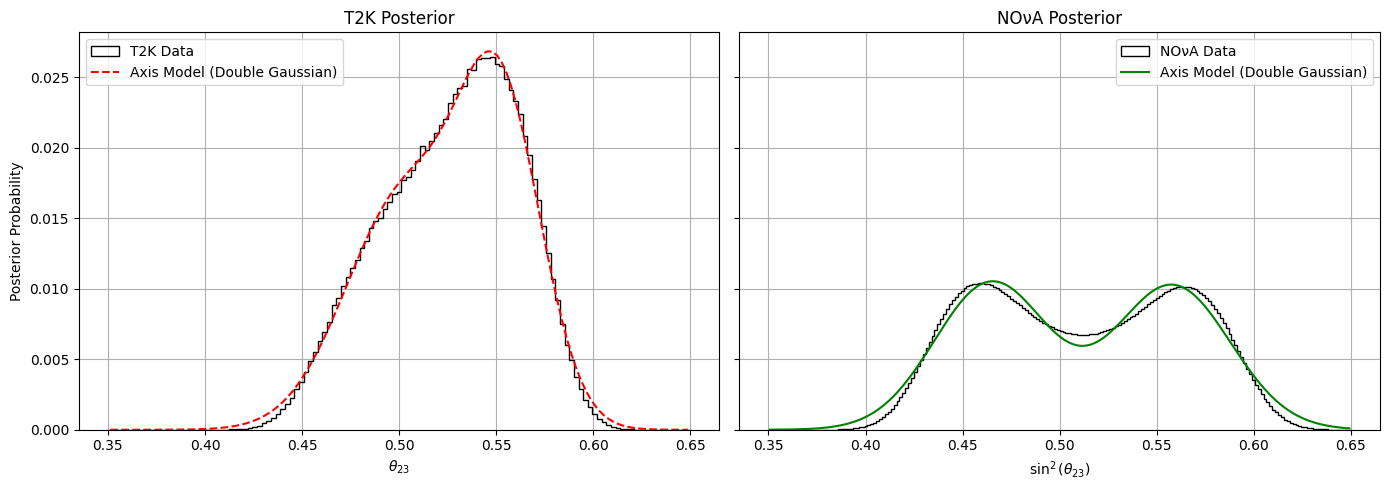

T2K Posterior Fit:
  RMSE: 0.0003
  R²: 0.9986
  χ²: 0.0072
  p: 1.0000
  AIC: -1977.9301
  BIC: -1960.9602

NOvA Posterior Fit:
  RMSE: 0.0005
  R²: 0.9829
  χ²: 0.0236
  p: 1.0000
  AIC: -3013.4354
  BIC: -2993.6455


In [ ]:
# === INSTALL & IMPORT ===
!pip install uproot awkward --quiet

import numpy as np
import matplotlib.pyplot as plt
import uproot
import zipfile
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn.metrics import mean_squared_error, r2_score

# === DOWNLOAD AND LOAD T2K DATA ===
!wget -q https://zenodo.org/record/7741399/files/T2K_arxiv2303.03222_DataRelease.zip
with zipfile.ZipFile("T2K_arxiv2303.03222_DataRelease.zip", 'r') as zip_ref:
    zip_ref.extractall("T2K_Data")
t2k_file = uproot.open("T2K_Data/Bayesian_DataRelease.root")
t2k_hist = t2k_file["h1D_th23posterior_wRC_NH;1"]
t2k_counts, t2k_edges = t2k_hist.to_numpy()
t2k_x = (t2k_edges[:-1] + t2k_edges[1:]) / 2
t2k_y = t2k_counts

# === LOAD NOvA DATA ===
nova_file = uproot.open("posteriors_worc_indep-ord-marg.root")
nova_hist = nova_file["contours_worc_cond_posterior_1D_worc_ssth23_NO;1"]
nova_counts, nova_edges = nova_hist.to_numpy()
nova_x = (nova_edges[:-1] + nova_edges[1:]) / 2
nova_y = nova_counts

# === DOUBLE GAUSSIAN MODEL ===
def double_gaussian(x, mu1, sigma1, amp1, mu2, sigma2, amp2):
    return (amp1 * np.exp(-0.5 * ((x - mu1) / sigma1)**2) +
            amp2 * np.exp(-0.5 * ((x - mu2) / sigma2)**2))

# === STATS FUNCTION ===
def evaluate(y_true, y_pred, n_params):
    obs = y_true / np.sum(y_true)
    pred = y_pred / np.sum(y_pred)
    chi2, p = chisquare(f_obs=obs, f_exp=pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    aic = n * np.log(ss_res / n) + 2 * n_params
    bic = n * np.log(ss_res / n) + n_params * np.log(n)
    return {"RMSE": rmse, "R²": r2, "χ²": chi2, "p": p, "AIC": aic, "BIC": bic}

# === FIT BOTH DATASETS (RAISE maxfev TO ENSURE CONVERGENCE) ===
# T2K: peaks close together (may merge into unimodal)
params_t2k, _ = curve_fit(double_gaussian, t2k_x, t2k_y,
                          p0=[0.53, 0.02, 0.015, 0.55, 0.02, 0.01],
                          maxfev=10000)
fit_t2k = double_gaussian(t2k_x, *params_t2k)

# NOvA: clear two peaks
params_nova, _ = curve_fit(double_gaussian, nova_x, nova_y,
                           p0=[0.45, 0.015, 0.01, 0.56, 0.015, 0.01],
                           maxfev=10000)
fit_nova = double_gaussian(nova_x, *params_nova)

# === PLOT RESULTS ===
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].hist(t2k_x, bins=t2k_edges, weights=t2k_y, histtype='step', color='black', label='T2K Data')
axs[0].plot(t2k_x, fit_t2k, 'r--', label='Axis Model (Double Gaussian)')
axs[0].set_title('T2K Posterior')
axs[0].set_xlabel(r'$\theta_{23}$')
axs[0].set_ylabel('Posterior Probability')
axs[0].legend()
axs[0].grid(True)

axs[1].hist(nova_x, bins=nova_edges, weights=nova_y, histtype='step', color='black', label='NOνA Data')
axs[1].plot(nova_x, fit_nova, 'g-', label='Axis Model (Double Gaussian)')
axs[1].set_title('NOνA Posterior')
axs[1].set_xlabel(r'$\sin^2(\theta_{23})$')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# === EXPORT FIGURE FOR OVERLEAF ===
fig.savefig("figure5_X_axis_model_t2k_vs_nova.pdf", dpi=600, bbox_inches='tight')
fig.savefig("figure5_X_axis_model_t2k_vs_nova.png", dpi=600, bbox_inches='tight')

# === EVALUATE ===
print("T2K Posterior Fit:")
for k, v in evaluate(t2k_y, fit_t2k, 6).items():
    print(f"  {k}: {v:.4f}")

print("\nNOvA Posterior Fit:")
for k, v in evaluate(nova_y, fit_nova, 6).items():
    print(f"  {k}: {v:.4f}")
